In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from utils import wrc

In [2]:
file = r'/scratch/project_2000908/nousu/SpaFHy_RESULTS/kuivis_32_5_24.nc'
results = xr.open_dataset(file)

In [4]:
res = results[['bucket_moisture_root', 'bucket_moisture_top', 'bucket_psi_root']]

In [6]:
results.close()

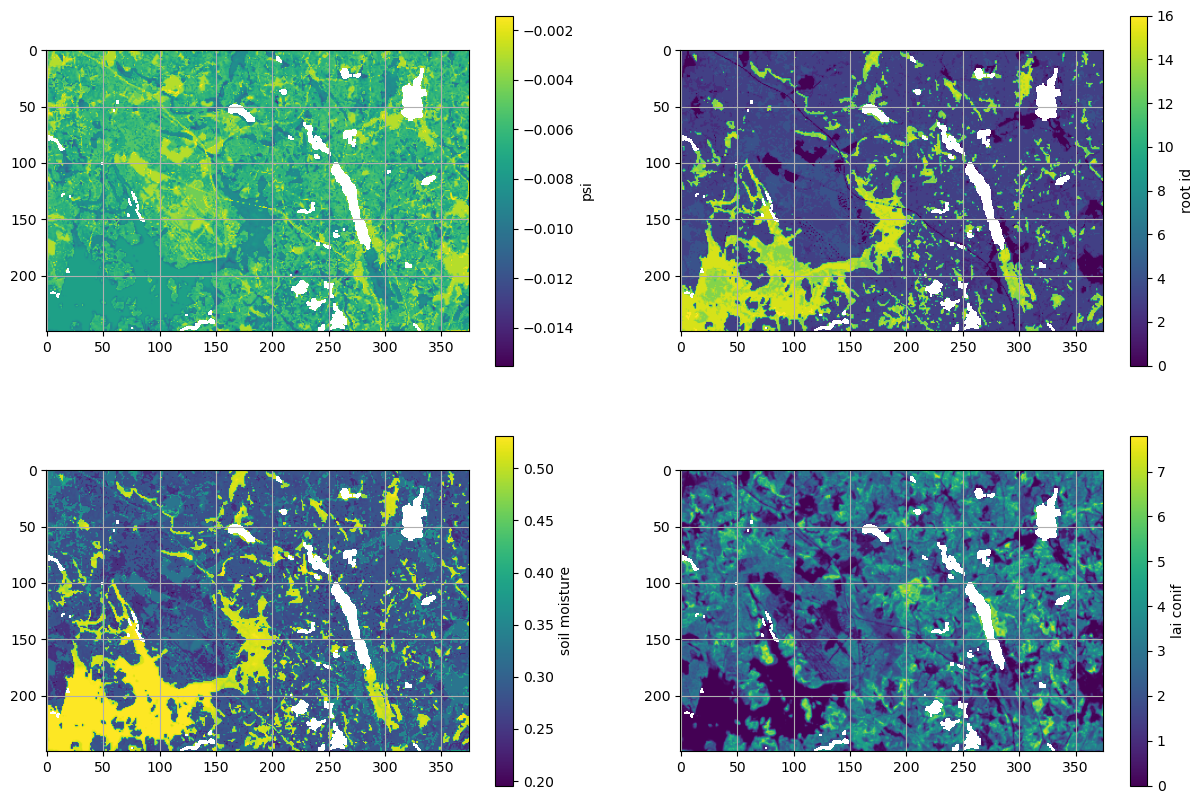

In [3]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
im1 = axs[0][0].imshow(results['bucket_psi_root'].sel(time='1981-08-01'))
im2 = axs[1][0].imshow(results['bucket_moisture_root'].sel(time='1981-08-01'))
im3 = axs[0][1].imshow(results['parameters_root_id'])
im4 = axs[1][1].imshow(results['parameters_lai_conif'])

axs[0][0].grid()
axs[1][0].grid()
axs[0][1].grid()
axs[1][1].grid()

plt.colorbar(im1, label='psi')
plt.colorbar(im2, label='soil moisture')
plt.colorbar(im3, label='root id')
plt.colorbar(im4, label='lai conif')

#plt.savefig(f'psi_test.png', bbox_inches='tight', dpi=300)

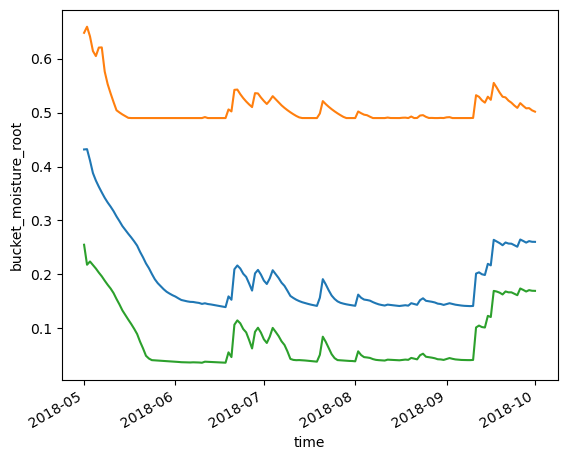

In [16]:
res['bucket_moisture_root'].sel(time=slice('2018-05-01', '2018-10-01')).mean(dim=['lat','lon']).plot()
res['bucket_moisture_root'].sel(time=slice('2018-05-01', '2018-10-01')).max(dim=['lat','lon']).plot()
res['bucket_moisture_root'].sel(time=slice('2018-05-01', '2018-10-01')).min(dim=['lat','lon']).plot()

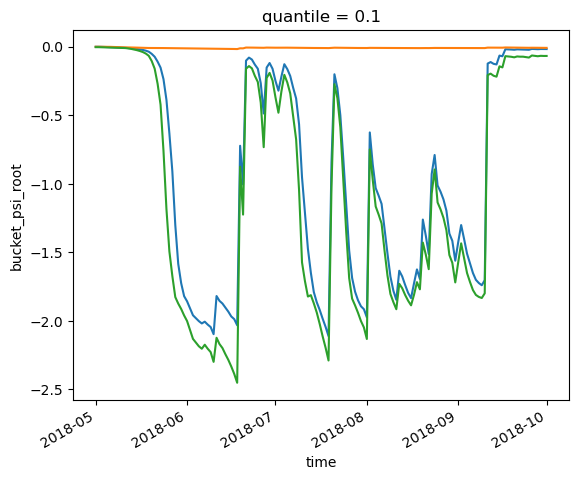

In [15]:
import matplotlib.pyplot as plt
res['bucket_psi_root'].sel(time=slice('2018-05-01', '2018-10-01')).quantile(0.5, dim=['lat','lon']).plot()
res['bucket_psi_root'].sel(time=slice('2018-05-01', '2018-10-01')).quantile(0.9, dim=['lat','lon']).plot()
res['bucket_psi_root'].sel(time=slice('2018-05-01', '2018-10-01')).quantile(0.1, dim=['lat','lon']).plot()
#plt.ylim([-10,0])

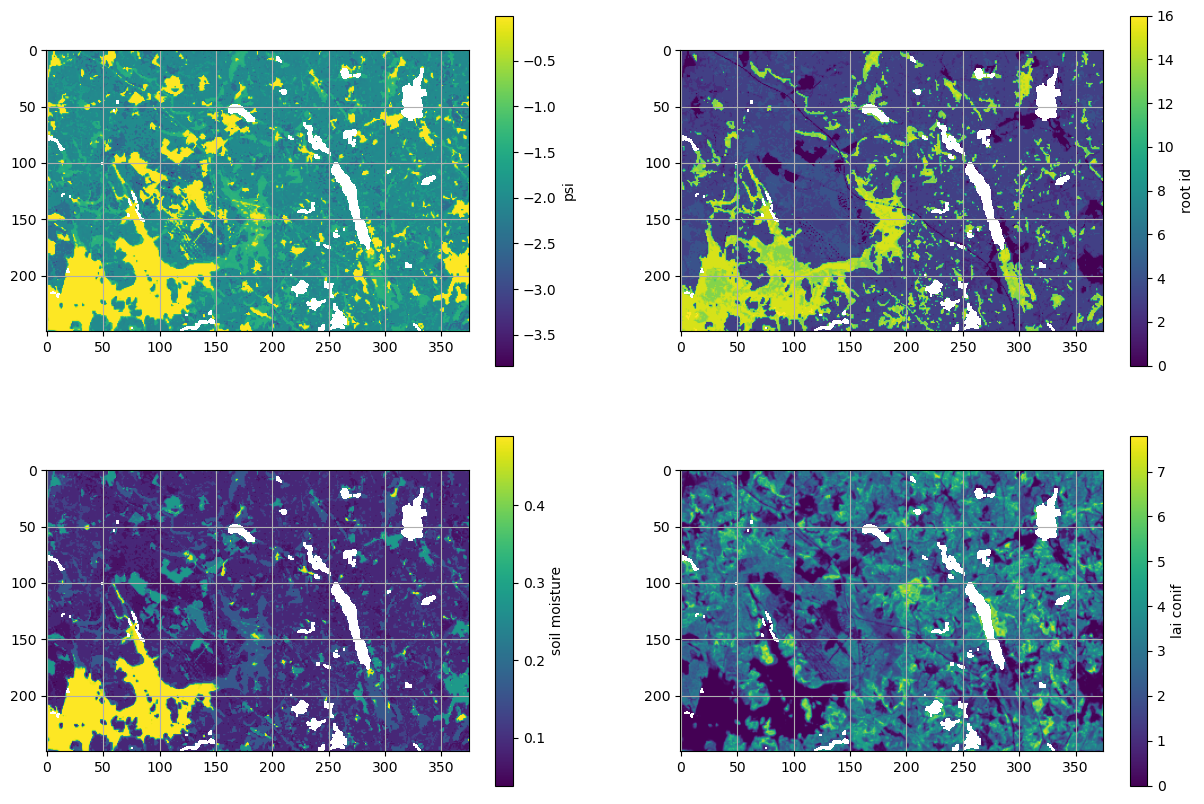

In [12]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
im1 = axs[0][0].imshow(results['bucket_psi_root'].sel(time='2018-08-01'))
im2 = axs[1][0].imshow(results['bucket_moisture_root'].sel(time='2018-08-01'))
im3 = axs[0][1].imshow(results['parameters_root_id'])
im4 = axs[1][1].imshow(results['parameters_lai_conif'])

axs[0][0].grid()
axs[1][0].grid()
axs[0][1].grid()
axs[1][1].grid()

plt.colorbar(im1, label='psi')
plt.colorbar(im2, label='soil moisture')
plt.colorbar(im3, label='root id')
plt.colorbar(im4, label='lai conif')

In [7]:
print(results['bucket_psi_root'].sel(time='1981-08-01')[160,345].data, 'MPa')
print(results['bucket_moisture_root'].sel(time='1981-08-01')[160,345].data, 'm3 m-3')
print(results['parameters_root_id'][160,345].data, 'id')

-0.06858525 MPa
0.47636792 m3 m-3
13.0 id


In [22]:
print(results['bucket_psi_root'].sel(time='1981-08-01')[163,348].data, 'MPa')
print(results['bucket_moisture_root'].sel(time='1981-08-01')[163,348].data, 'm3 m-3')
print(results['parameters_root_id'][163,348].data, 'id')

-0.043995462 MPa
0.5110437 m3 m-3
14.0 id


In [5]:
# THIS FUNCTION IS USED IN BUCKED GRID!
def theta_psi(pF, Wliq_root):
    """
    converts vol. water content (m3m-3) to soil water potential (MPa)
    """
    eps = np.finfo(float).eps
    
    n = pF['n'][0]
    m = 1 - 1 / n
    # converts water content (m3m-3) to potential (m)
    x = np.minimum(Wliq_root, pF['ThetaS'][0])
    x = np.maximum(x, pF['ThetaR'][0])  # checks limits
        
    s = (pF['ThetaS'][0] - pF['ThetaR'][0]) / ((x - pF['ThetaR'][0]) + eps)

    Psi = -1 / pF['alpha'][0]*(s**(1.0 / m) - 1.0)**(1.0 / n)  # kPa (IF ALPHA IN KPA-1!)
    #Psi[Psi==np.NaN] = 0.0
    Psi = 1e-3*Psi # kPa to MPa
    #Psi[Psi<-3.0] = -3.0
        
    return Psi

def psi_theta(pF, psi):
    m = 1 - 1 / pF['n'][0]
    # converts water potential [m] to water content [m3 m-3]
    psi = 1000*np.minimum(psi, 0)  # kPa
    Th = pF['ThetaR'][0] + (pF['ThetaS'][0] - pF['ThetaR'][0]) / (1 + abs(pF['alpha'][0]*psi)**pF['n'][0])**m
    return Th

In [7]:
pF = {  # vanGenuchten water retention parameters
    'ThetaS': [0.92],  # MEASURED
    'ThetaR': [0.098], # MEASURED 
    'alpha': [0.7],  # MEASURED 
    'n': [1.37]} # MEASURED
print(theta_psi(pF=pF, Wliq_root=0.49091675), 'MPa')
print(theta_psi(pF=pF, Wliq_root=0.16066474), 'MPa')
print(theta_psi(pF=pF, Wliq_root=0.3636792), 'MPa')
print('')
print(psi_theta(pF=pF, psi=-0.010000000237856553), 'm3m-3')
print(psi_theta(pF=pF, psi=-1.5000001782187294), 'm3m-3')
print(psi_theta(pF=pF, psi=-0.029904666867342417), 'm3m-3')

-0.010000000237856554 MPa
-1.5000001782187296 MPa
-0.029904666867342417 MPa

0.49091675000000023 m3m-3
0.1606647400000002 m3m-3
0.3636792000000002 m3m-3


In [8]:
sim_Wliq_root = results['bucket_moisture_root'].sel(time='1981-07-01')[160,345].data
sim_psi = results['bucket_psi_root'].sel(time='1981-07-01')[160,345].data
print('simulated Wliq_root =', sim_Wliq_root, 'm3m-3')
print('simulated psi =', sim_psi, 'MPa')
print('converted Wliq_root -> psi =', theta_psi(pF=pF, Wliq_root=sim_Wliq_root), 'MPa')
print('converted psi -> Wliq_root =', psi_theta(pF=pF, psi=sim_psi), 'MPa')

simulated Wliq_root = 0.5604867 m3m-3
simulated psi = -0.0061636353 MPa
converted Wliq_root -> psi = -0.006163635694380299 MPa
converted psi -> Wliq_root = 0.5604866841723577 MPa


field capacity: [0.49091675]
wilting point: [0.16066474]
-1.5 MPa =  [0.16066474] m3 m-3


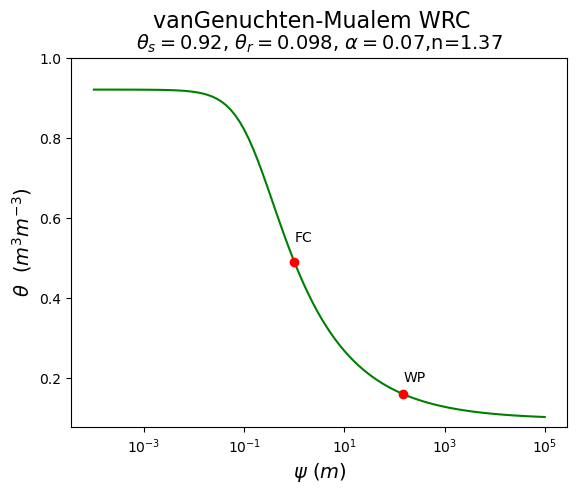

In [38]:
# WRC FUNCTION IS IN THE UTILS, AND IT OPERATES BETWEEN [m] AND [m3 m-3]! NOTE THEREFORE ALPHA PARAMETER
pF = {  # vanGenuchten water retention parameters
    'ThetaS': [0.92],  # MEASURED
    'ThetaR': [0.098], # MEASURED 
    'alpha': [0.07],  # MEASURED
    'n': [1.37]} # MEASURED
wrc(pF=pF, draw_pF=True)
print('field capacity:', wrc(pF=pF, psi=-1)) # 
print('wilting point:', wrc(pF=pF, psi=-150)) # 
print('-1.5 MPa = ', wrc(pF=pF, psi=-150), 'm3 m-3') # 